In [ ]:
#GAN Music generation code

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from music21 import converter, instrument, note, chord, stream
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
SEQUENCE_LENGTH = 200
LATENT_DIMENSION = 1500
BATCH_SIZE = 32
EPOCHS = 80
SAMPLE_INTERVAL = 1

In [3]:
from music21 import converter, note, chord
from pathlib import Path

def get_notes(folder_path):
    """ Get all the notes and chords from the MIDI files """
    notes = []

    for file in Path(folder_path).glob("*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

# Example usage:
notes = get_notes("E:\\Piano Dataset\\LSTM_Generated_music_real")

Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_1.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_10.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_100.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_101.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_102.mid


E:\anaconda3\lib\site-packages\music21\stream\base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_103.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_104.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_105.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_106.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_107.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_108.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_109.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_11.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_110.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_111.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_112.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_113.mid
Parsing E:\Piano Dataset\LSTM_Generated_music_real\generated_music_114.mid
Parsing E:\Piano Dataset\L

In [4]:
print(len(notes))
print(len(list(set(notes))))

20000
211


In [5]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 200

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalize input between -1 and 1
    network_input = (network_input - float(n_vocab) / 2) / (float(n_vocab) / 2)
    network_output = to_categorical(network_output, num_classes=n_vocab)  # Use to_categorical from TensorFlow's Keras

    return network_input, network_output  # Add this return statement

In [6]:
def create_midi(prediction_output, filename):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for item in prediction_output:
        pattern = item[0]
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))


In [33]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1500
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):
        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        
        # Adding Minibatch Discrimination
        model.add(Dense(100))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        n_vocab = len(set(notes))
        X_train, y_train = prepare_sequences(notes, n_vocab)

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Training the discriminator
            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            #noise = np.random.choice(range(484), (batch_size, self.latent_dim))
            #noise = (noise-242)/242
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as real)
            g_loss = self.combined.train_on_batch(noise, real)

            # Print the progress and save into loss lists
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
        
        self.generate(notes)
        print('length of notes:',len(notes))
        print("\nLoss curve")
        self.plot_loss()
        
    def generate(self, input_notes):
        # Get pitch names and store in a dictionary
        notes = input_notes
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        # Use random noise to generate sequences
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        
        pred_notes = [x*242+242 for x in predictions[0]]
        
        # Map generated integer indices to note names, with error handling
        pred_notes_mapped = []
        for x in pred_notes:
            index = int(x)
            if index in int_to_note:
                pred_notes_mapped.append(int_to_note[index])
            else:
                # Fallback mechanism: Choose a default note when the index is out of range
                pred_notes_mapped.append('C5')  # You can choose any default note here
        
        create_midi(pred_notes_mapped, 'gan_final')
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()


In [36]:
import tensorflow as tf
import os
gan = GAN(rows=SEQUENCE_LENGTH)    

# Get the list of trainable variables
trainable_vars = gan.combined.trainable_variables

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
optimizer.build(trainable_vars)

# Set the optimizer for the combined model
gan.combined.optimizer = optimizer

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200, 512)          1052672   
                                                                 
 bidirectional_6 (Bidirecti  (None, 1024)              4198400   
 onal)                                                           
                                                                 
 dense_48 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 256)               0         
                                                     

In [37]:
# Train the model
gan.train(epochs=EPOCHS, batch_size=BATCH_SIZE, sample_interval=SAMPLE_INTERVAL)

1/1 [==============================] - 0s 199ms/step
0 [D loss: 0.696270, acc.: 23.44%] [G loss: 0.690969]
1/1 [==============================] - 0s 18ms/step
1 [D loss: 0.682550, acc.: 60.94%] [G loss: 0.689874]
1/1 [==============================] - 0s 48ms/step
2 [D loss: 0.663680, acc.: 70.31%] [G loss: 0.684281]
1/1 [==============================] - 0s 47ms/step
3 [D loss: 0.627884, acc.: 79.69%] [G loss: 0.675129]
1/1 [==============================] - 0s 47ms/step
4 [D loss: 0.569997, acc.: 71.88%] [G loss: 0.664772]
1/1 [==============================] - 0s 47ms/step
5 [D loss: 0.709196, acc.: 71.88%] [G loss: 0.737954]
1/1 [==============================] - 0s 47ms/step
6 [D loss: 0.365897, acc.: 87.50%] [G loss: 0.783824]
1/1 [==============================] - 0s 48ms/step
7 [D loss: 0.765651, acc.: 81.25%] [G loss: 0.910107]
1/1 [==============================] - 0s 54ms/step
8 [D loss: 0.413320, acc.: 87.50%] [G loss: 0.960508]
1/1 [==============================] - 0s 31m

In [13]:
def generate_music(generator_model, latent_dim, n_vocab, length=2000):
        noise = np.random.normal(0, 1, (1, latent_dim))
        predictions = generator_model.predict(noise)
        pred_notes = [x * (n_vocab / 2) + (n_vocab / 2) for x in predictions[0]]
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        pred_notes_mapped = [int_to_note[int(x)] for x in pred_notes]
    
        return pred_notes_mapped[:length]

In [15]:
#Generate music
n_vocab = len(set(notes))
output_folder = "E:\\Piano Dataset\\GAN_Generated_music"
os.makedirs(output_folder, exist_ok=True)
# Generate and save 100 new music sequences
for i in range(100):
    generated_music = generate_music(gan.generator, LATENT_DIMENSION, n_vocab)
    # Print the chords/notes present in the generated music
    print(f"Chords/Notes in generated_music_{i}: {[str(elem) for elem in generated_music]}")
    create_midi(generated_music, os.path.join(output_folder, f'gan_music_{i}.mid'))

1/1 [==============================] - 0s 47ms/step
Chords/Notes in generated_music_0: ['0.1', 'G6', 'G3', '0.3', '4.7', 'E2', 'D6', 'C#2', '0.2.6', '11.1', '7.11', '6.9.0', 'C4', '0.3', '4.9', '1.4', '10.3', '0.3.7', '10.0.4', '0.2', '0.4.7', '1.4.6', '10.0', '0.3.5', '0.4.7', 'B-4', '0.1', '10.11.1.2', '0.2.6', '1.5', '0.4.7', '1.4.7', '8.11', '11.1.5', '0.2.6', '10.11.1.2', '11.0', '5.11', '8.10.2', 'D5', '0.2.6', '3.6.10', 'D2', 'C#7', '1.3', '0.3', 'E-2', '2.5.9', '5.10', 'G3', 'G2', '4.7.11', '3.8', '7.10.1.3', 'E2', 'G4', '0.1', '1.4.6', 'G5', 'G5', '1.5', '10.1.4', '1.3', 'G3', 'G#2', 'F4', '3.5.9', 'G#3', '2.4', '0.3.5', '6.8', 'D4', 'G#4', 'F#5', 'C#4', '7.11.2', '0.4.7', '10.3', '10.1.5', 'A4', '1.4.6', '5.8.10', '0.6', '1.7', 'G4', 'C#6', '3.6.10', '7.8.10.11', 'G6', '1.4.8', 'B5', '1.4.6', '10.2', 'G2', '10.0', '0.3.6', '0.3.6', 'F6', '7.10.2', '3.7', 'G#1', '6.9', 'G#3', '11.2.4', '0.3.6', 'F#4', 'F#2', '6.9.1', '1.2', '3.7.10', '2.6.9', '0.1', 'G#2', 'G1', 'G#4', 'F#2', 

"\nfor i in range(10):\n    generated_music = generate_music(gan.generator, LATENT_DIMENSION, n_vocab)\n    create_midi(generated_music, os.path.join(output_folder, f'generated_music_{i}'))  \n"

In [16]:
# Save the generator and discriminator models
gan.generator.save("generator_model.h5")
gan.discriminator.save("discriminator_model.h5")

E:\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


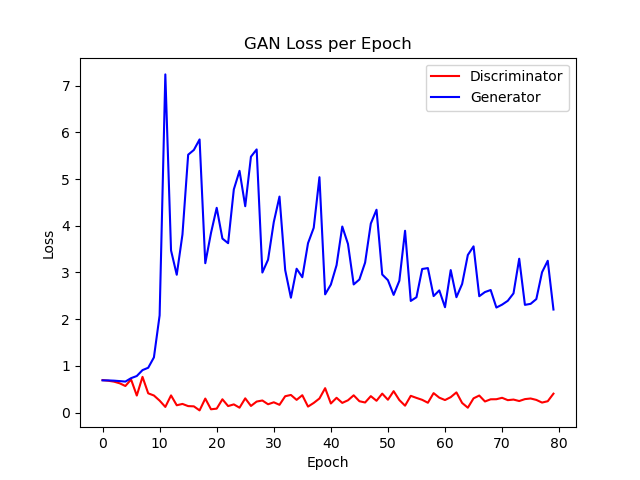

In [38]:
from IPython.display import Image

# Specify the path to your saved image
image_path = 'GAN_Loss_per_Epoch_final.png'

# Display the image using IPython's display function
Image(filename=image_path)

In [ ]:
# sample visualizations trying

In [40]:
from music21 import converter
import numpy as np
import glob

# Path to the folder containing generated MIDI files
folder_path = "E:/Piano Dataset/GAN_Generated_music"

# List all MIDI files in the folder
midi_files = glob.glob(folder_path + "/*.mid")

# Aggregate metrics
total_note_diversity = 0
aggregate_pitch_histogram = np.zeros(128)  # 128 MIDI pitches

# Process each MIDI file
for file_path in midi_files:
    generated_score = converter.parse(file_path)
    
    # Calculate note diversity for each file and aggregate
    unique_notes = set()
    for element in generated_score.recurse():
        if 'Note' in element.classes:
            unique_notes.add(element.pitch.midi)
    total_note_diversity += len(unique_notes)
    
    # Calculate pitch histogram for each file and aggregate
    for element in generated_score.recurse():
        if 'Note' in element.classes:
            aggregate_pitch_histogram[element.pitch.midi] += 1

# Compute average note diversity
average_note_diversity = total_note_diversity / len(midi_files)

# Normalize aggregate pitch histogram
aggregate_pitch_histogram /= len(midi_files)

print("Average Note Diversity:", average_note_diversity)
print("Aggregate Pitch Histogram:", aggregate_pitch_histogram)


Average Note Diversity: 10.98
Aggregate Pitch Histogram: [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 47.72 37.25 14.    6.83 18.97 23.77  6.21 46.86  6.06  9.12  0.    8.21
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]


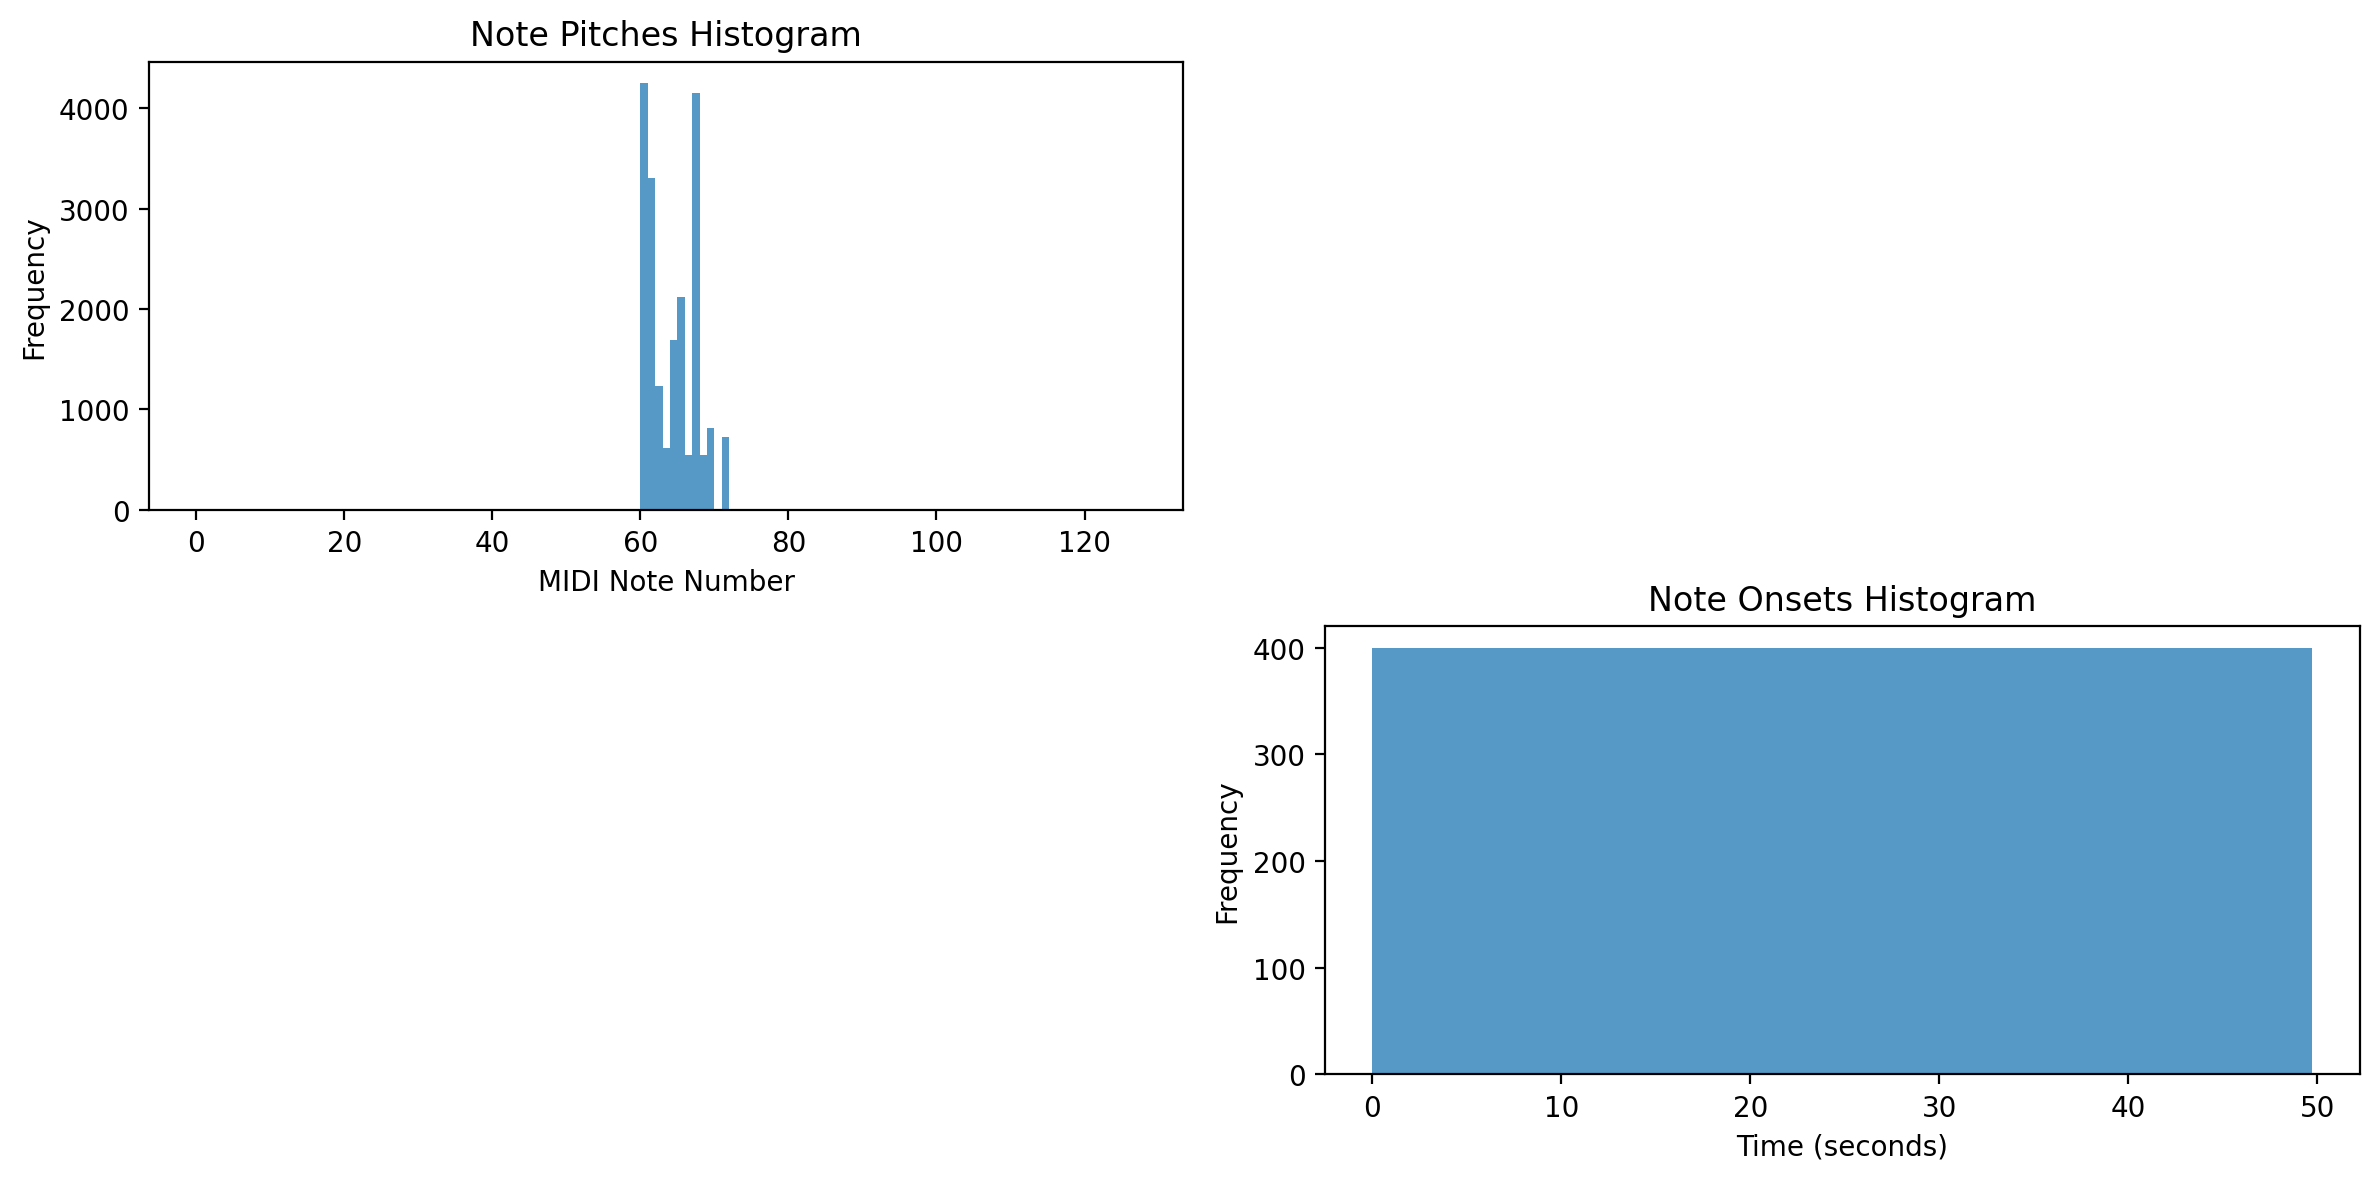

In [41]:
import os
import pretty_midi
import matplotlib.pyplot as plt

# Define the folder path containing MIDI files
directory_path = r"E:\Piano Dataset\GAN_Generated_music"

# Get a list of all MIDI files in the directory
midi_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".mid")]

# List to store extracted musical features
note_pitches = []
note_onsets = []

# Load MIDI files and extract features
for midi_file in midi_files:
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                note_pitches.append(note.pitch)
                note_onsets.append(note.start)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")

# Visualize musical features
plt.figure(figsize=(12, 6))

# Plot histograms
plt.subplot(2, 2, 1)
plt.hist(note_pitches, bins=range(128), alpha=0.75)
plt.title("Note Pitches Histogram")
plt.xlabel("MIDI Note Number")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.hist(note_onsets, bins=50, alpha=0.75)
plt.title("Note Onsets Histogram")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Pitch Interval')

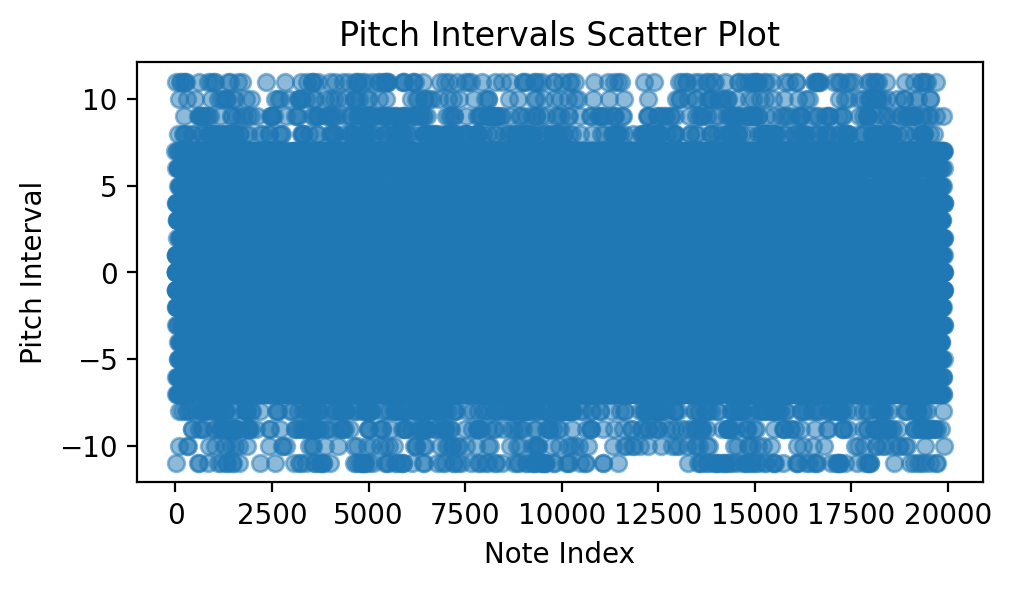

In [42]:
import numpy as np
pitch_intervals = []
note_counts = []
note_durations = []

# Load MIDI files and extract features
for midi_file in midi_files:
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        
        # Extract pitch intervals between consecutive notes
        note_onsets = [note.start for note in midi_data.instruments[0].notes]
        note_onsets.sort()
        for i in range(1, len(note_onsets)):
            pitch_intervals.append(midi_data.instruments[0].notes[i].pitch - midi_data.instruments[0].notes[i-1].pitch)
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")

# Visualize additional musical features
plt.figure(figsize=(12, 6))

# Pitch Intervals Scatter Plot
plt.subplot(2, 2, 1)
plt.scatter(range(len(pitch_intervals)), pitch_intervals, alpha=0.5)
plt.title("Pitch Intervals Scatter Plot")
plt.xlabel("Note Index")
plt.ylabel("Pitch Interval")

In [43]:
# Lists to store musical features
note_durations = []
pitch_ranges = []
unique_pitches = set()
pitch_intervals = []

# Load MIDI files and extract features
for midi_file in midi_files:
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        
        # Extract note durations,unique pitches and pitch intervals
        durations = [note.end - note.start for note in midi_data.instruments[0].notes if isinstance(note, pretty_midi.Note)]
        note_durations.extend(durations)
        pitches = [note.pitch for note in midi_data.instruments[0].notes if isinstance(note, pretty_midi.Note)]
        unique_pitches.update(pitches)
        intervals = [abs(pitches[i] - pitches[i-1]) for i in range(1, len(pitches))]
        pitch_intervals.extend(intervals)  
        
        # Extract pitch range (highest pitch - lowest pitch)
        pitches = [note.pitch for note in midi_data.instruments[0].notes if isinstance(note, pretty_midi.Note)]
        pitch_range = max(pitches) - min(pitches)
        pitch_ranges.append(pitch_range)
        
    except Exception as e:
        print(f"Error loading {midi_file}: {e}")

# Calculate average note duration and pitch range
average_note_duration = sum(note_durations) / len(note_durations)
average_pitch_range = sum(pitch_ranges) / len(pitch_ranges)
num_unique_pitches = len(unique_pitches)
average_pitch_interval = np.mean(pitch_intervals)
# Print analysis results
print(f"Average Note Duration: {average_note_duration:.2f} seconds")
print(f"Average Pitch Range: {average_pitch_range:.2f}")
print(f"Number of Unique Pitches: {num_unique_pitches}")
print(f"Average Pitch Interval: {average_pitch_interval:.2f}")

Average Note Duration: 0.45 seconds
Average Pitch Range: 11.00
Number of Unique Pitches: 11
Average Pitch Interval: 3.21


In [69]:
import os
import pretty_midi

directory_path = r"E:\Piano Dataset\GAN_Generated_music"
midi_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith(".mid")]

# Load a few MIDI files
num_files_to_load = 5
loaded_midis = []
for midi_file in midi_files[:num_files_to_load]:
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        loaded_midis.append(midi_data)
        print("Loaded:", midi_file)
    except Exception as e:
        print("Error loading {}: {}".format(midi_file, e))


Loaded: E:\Piano Dataset\GAN_Generated_music\gan_music_0.mid.mid
Loaded: E:\Piano Dataset\GAN_Generated_music\gan_music_1.mid.mid
Loaded: E:\Piano Dataset\GAN_Generated_music\gan_music_10.mid.mid
Loaded: E:\Piano Dataset\GAN_Generated_music\gan_music_11.mid.mid
Loaded: E:\Piano Dataset\GAN_Generated_music\gan_music_12.mid.mid


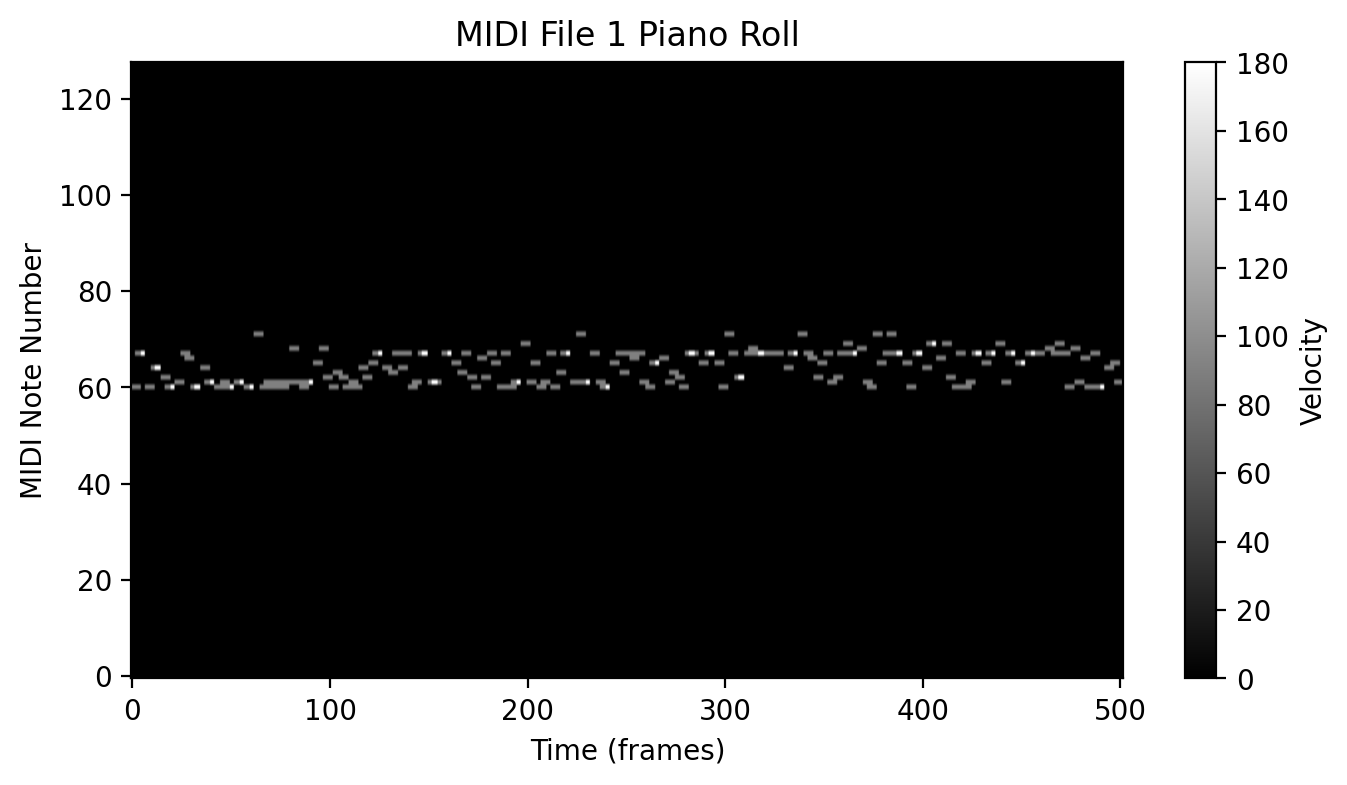

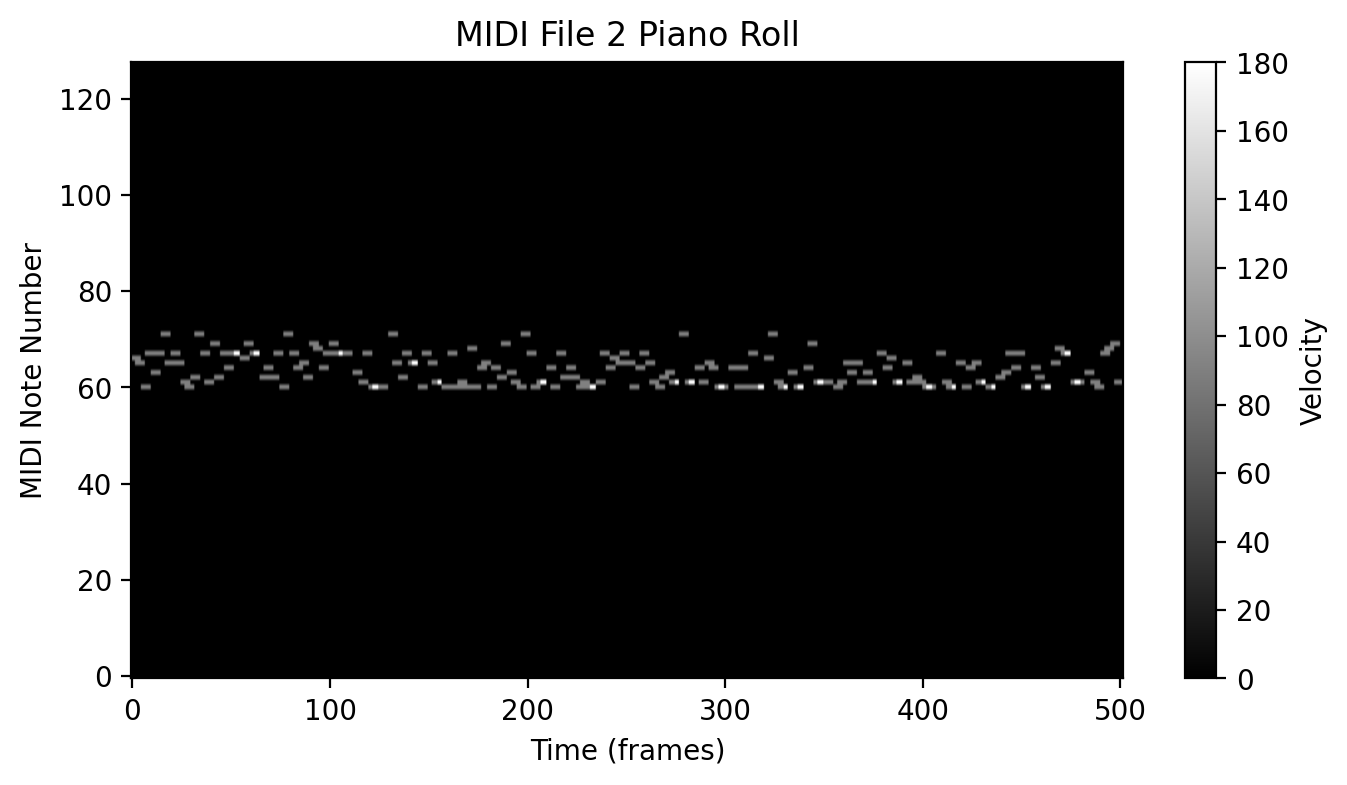

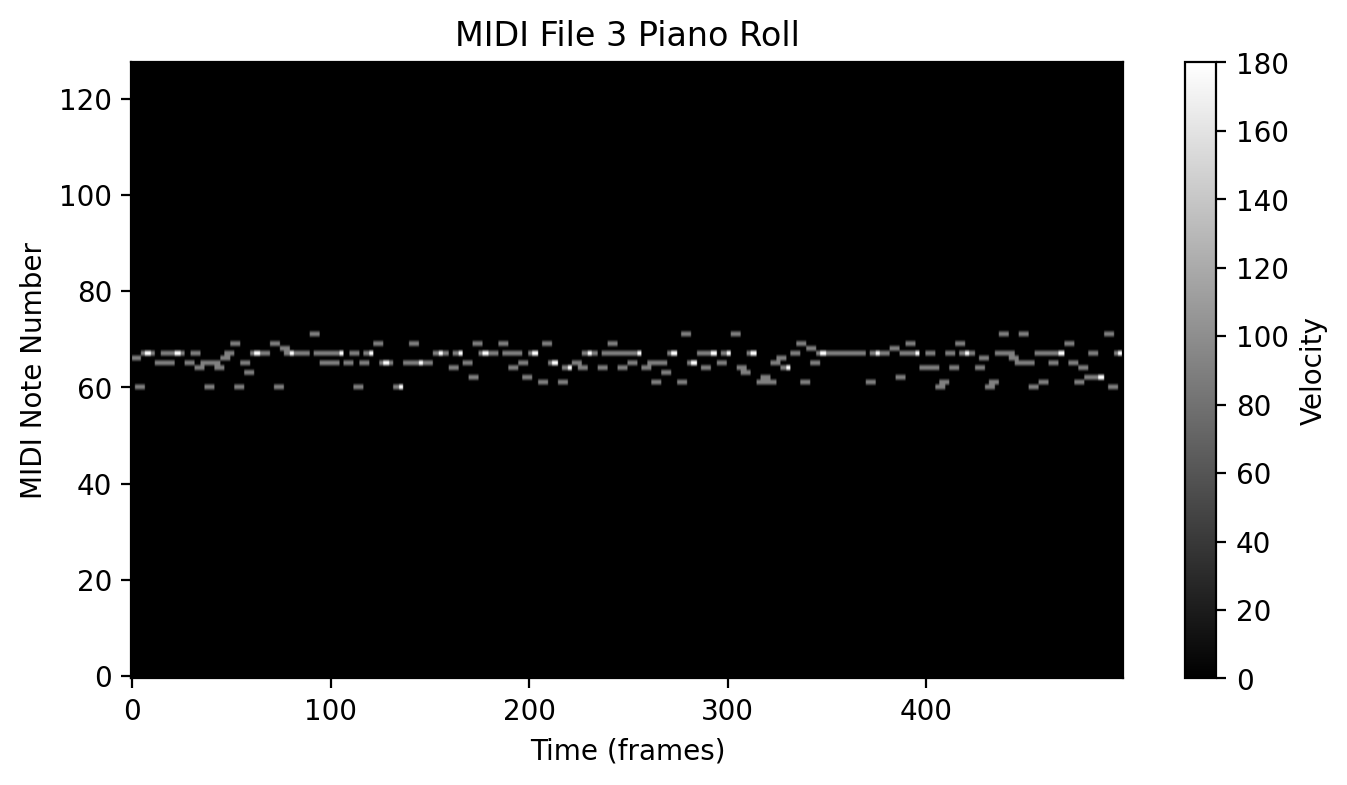

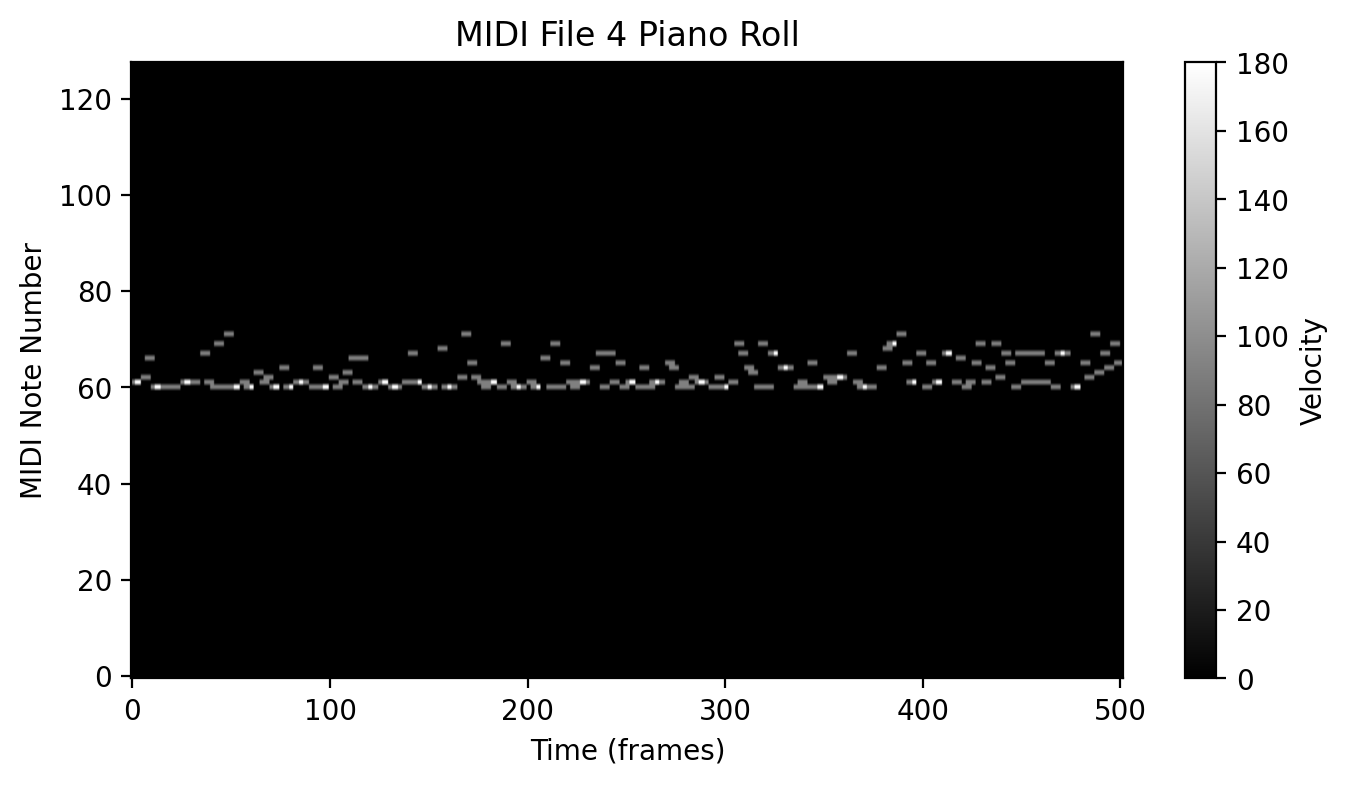

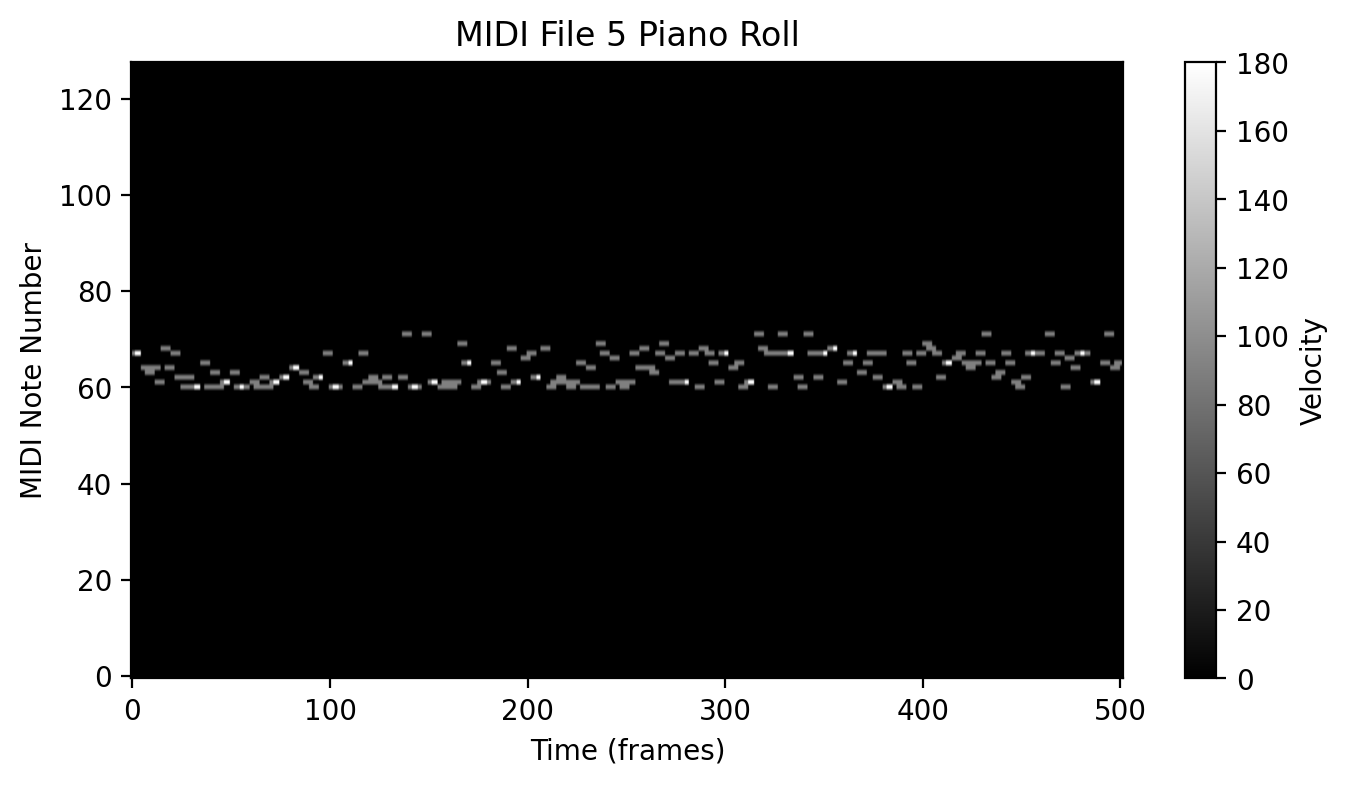

In [70]:
import matplotlib.pyplot as plt

# Visualize piano rolls for the loaded MIDI files
for i, midi_data in enumerate(loaded_midis):
    piano_roll = midi_data.get_piano_roll(fs=10)
    plt.figure(figsize=(8, 4))
    plt.imshow(piano_roll, origin="lower", aspect="auto", cmap="gray")
    plt.title(f"MIDI File {i+1} Piano Roll")
    plt.xlabel("Time (frames)")
    plt.ylabel("MIDI Note Number")
    plt.colorbar(label="Velocity")
    plt.show()

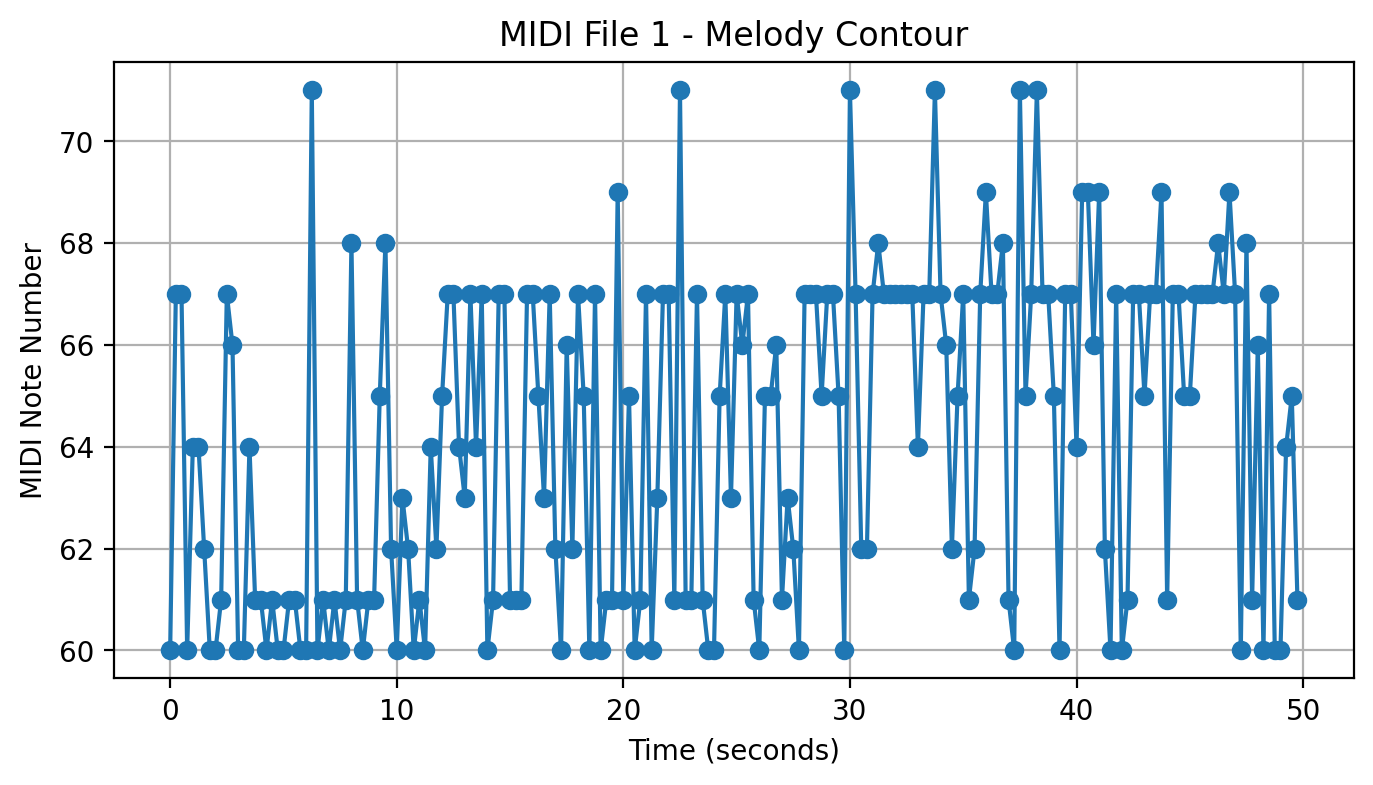

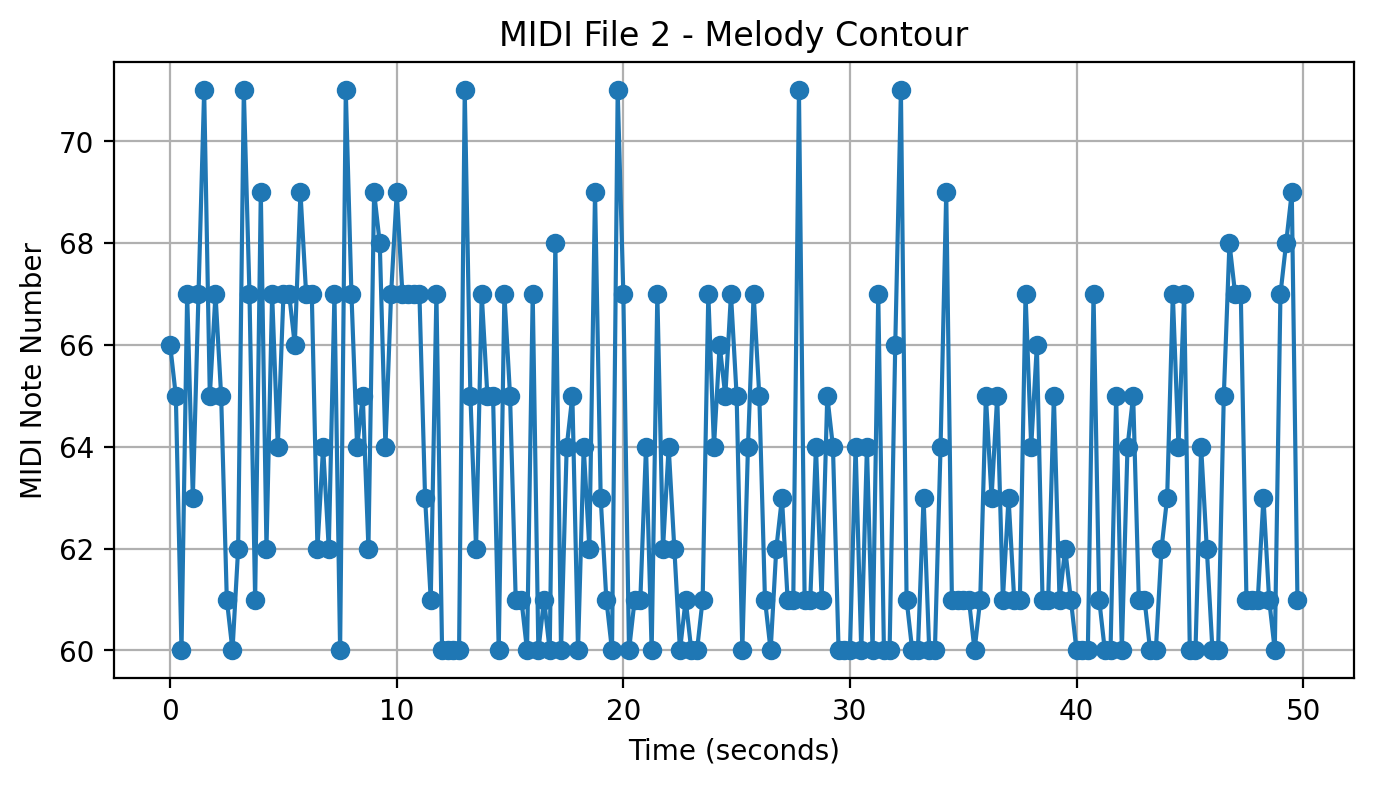

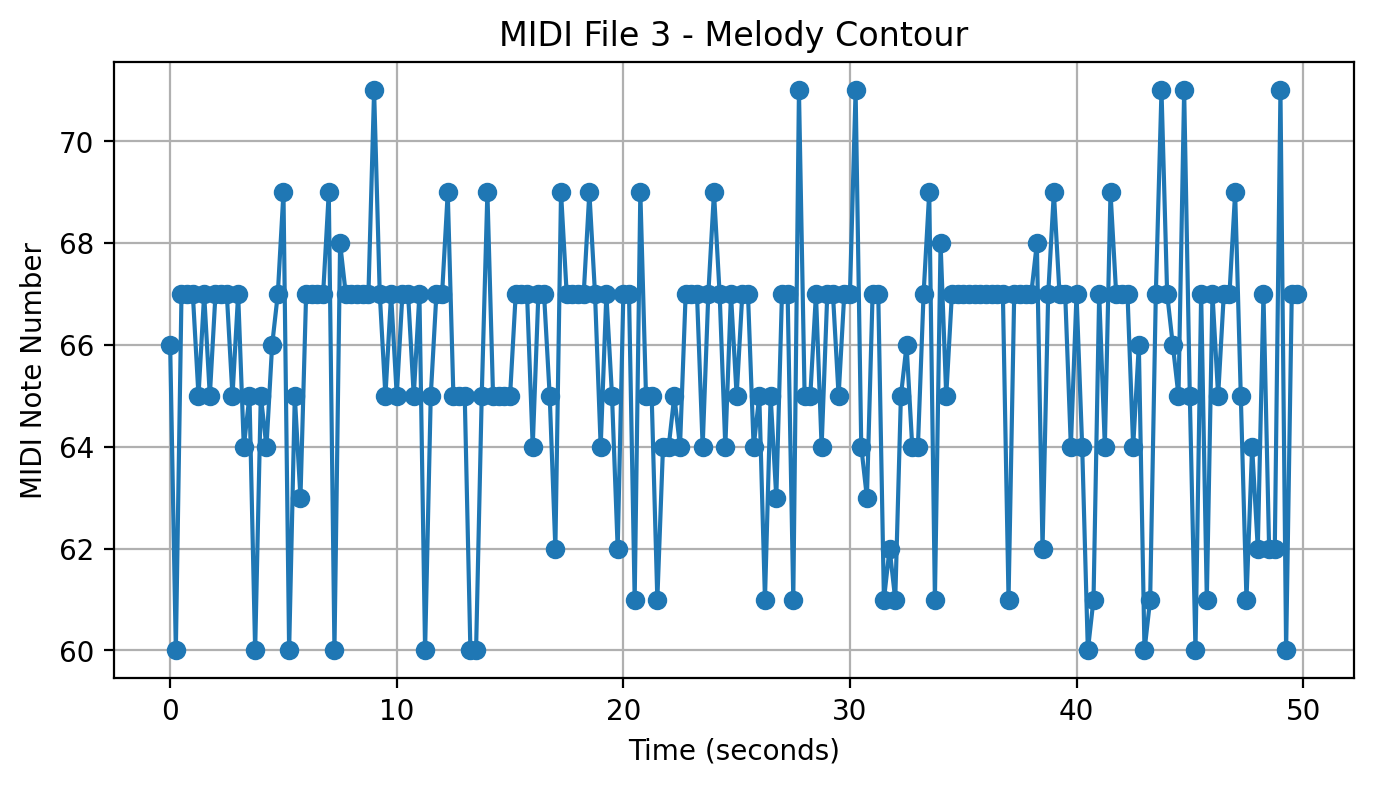

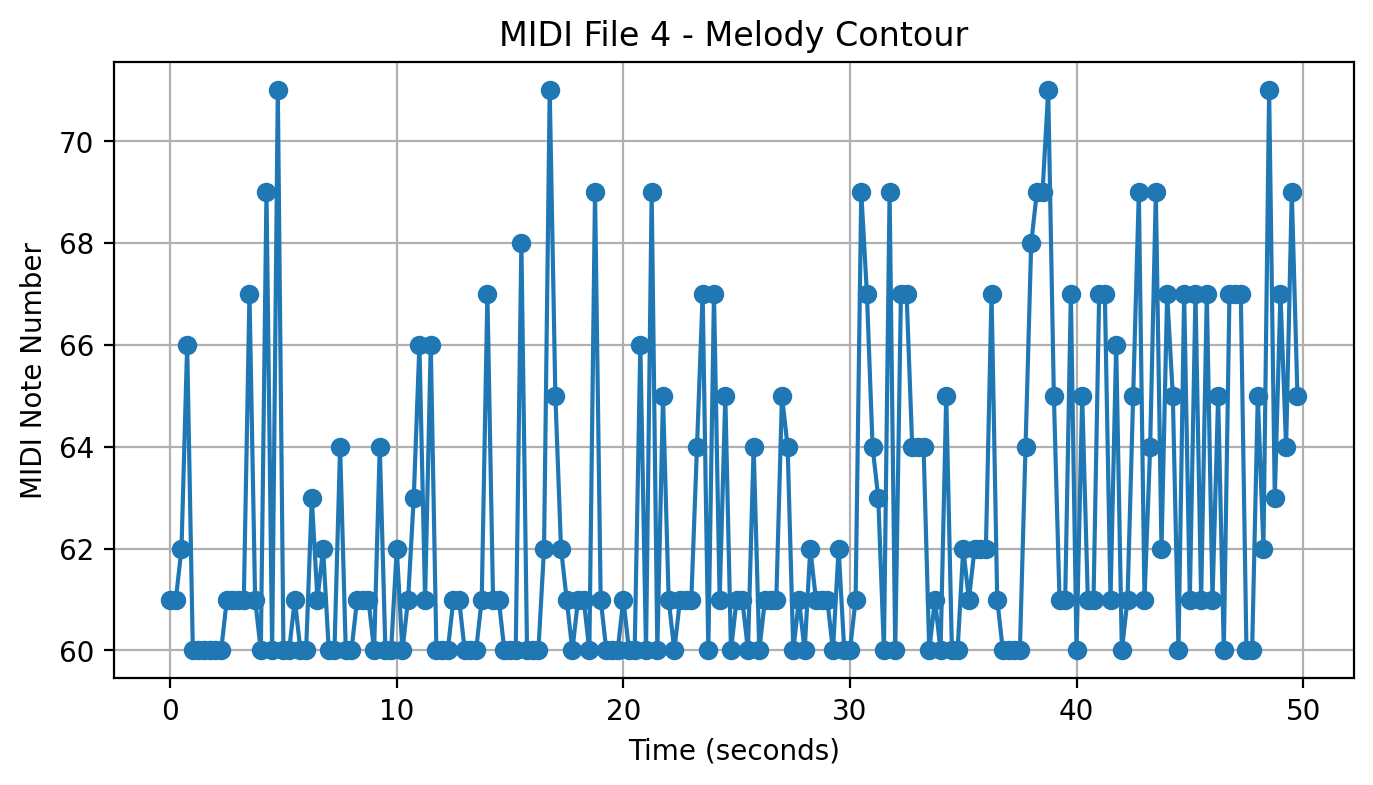

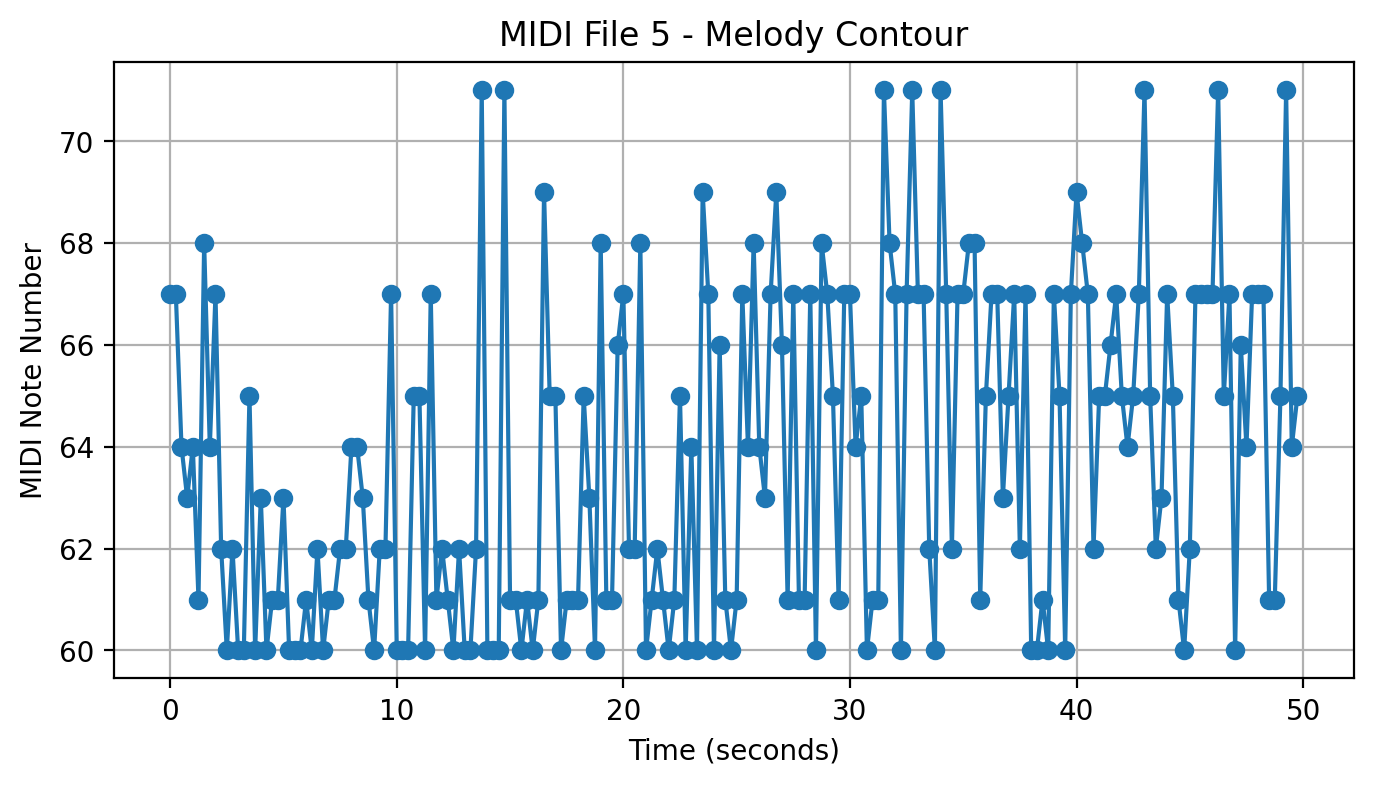

In [71]:
# Plot the melody contour for each MIDI file
for i, midi_data in enumerate(loaded_midis):
    note_onsets = [note.start for note in midi_data.instruments[0].notes]
    note_pitches = [note.pitch for note in midi_data.instruments[0].notes]
    plt.figure(figsize=(8, 4))
    plt.plot(note_onsets, note_pitches, marker='o', linestyle='-')
    plt.title(f"MIDI File {i+1} - Melody Contour")
    plt.xlabel("Time (seconds)")
    plt.ylabel("MIDI Note Number")
    plt.grid(True)
    plt.show()


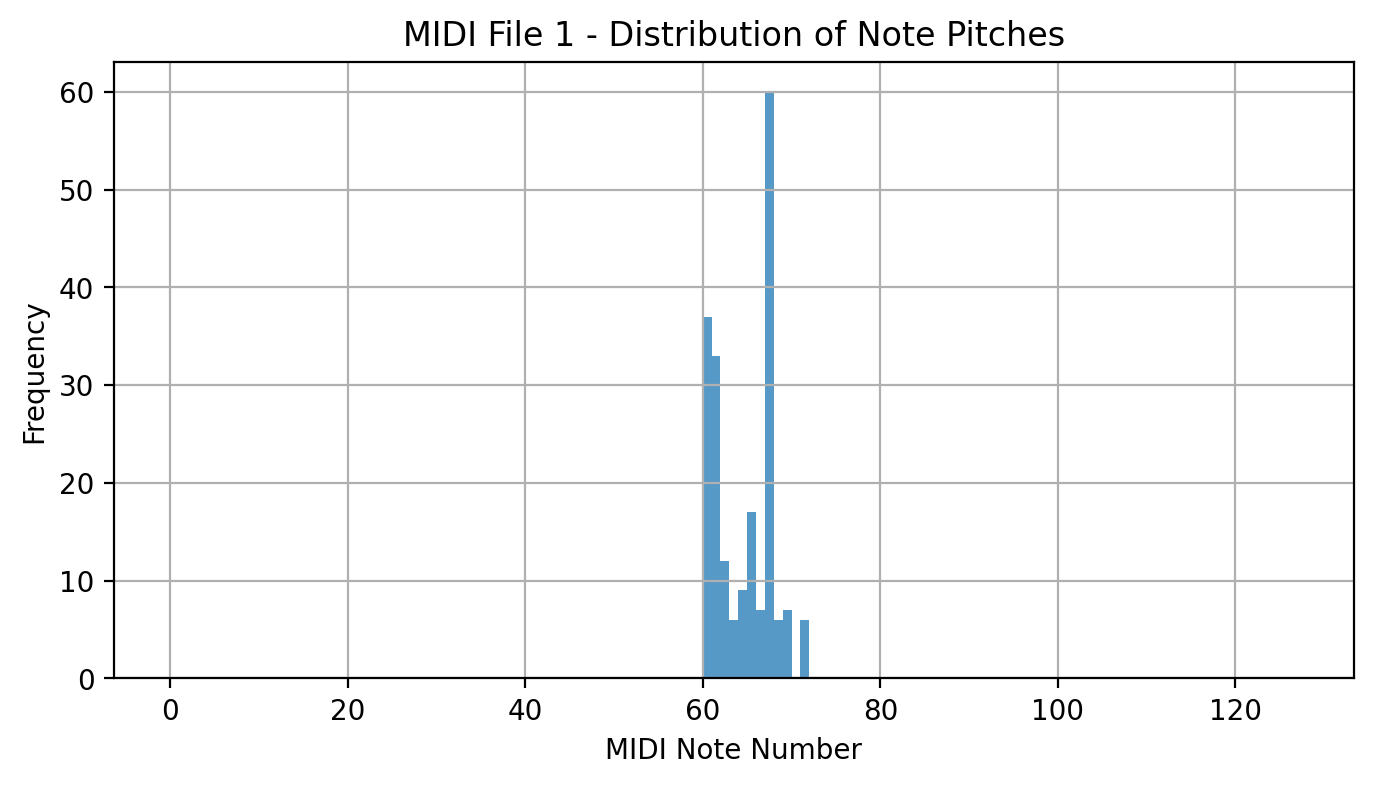

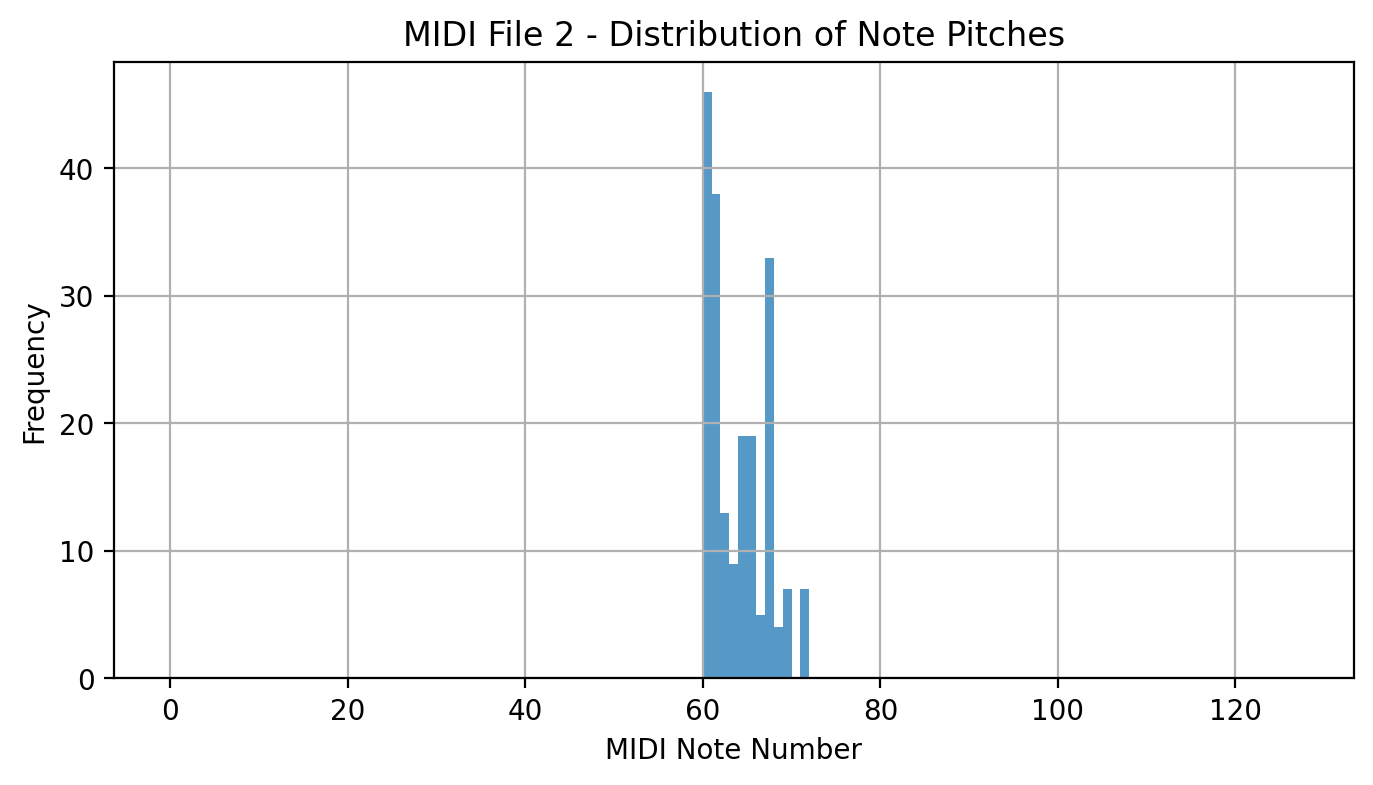

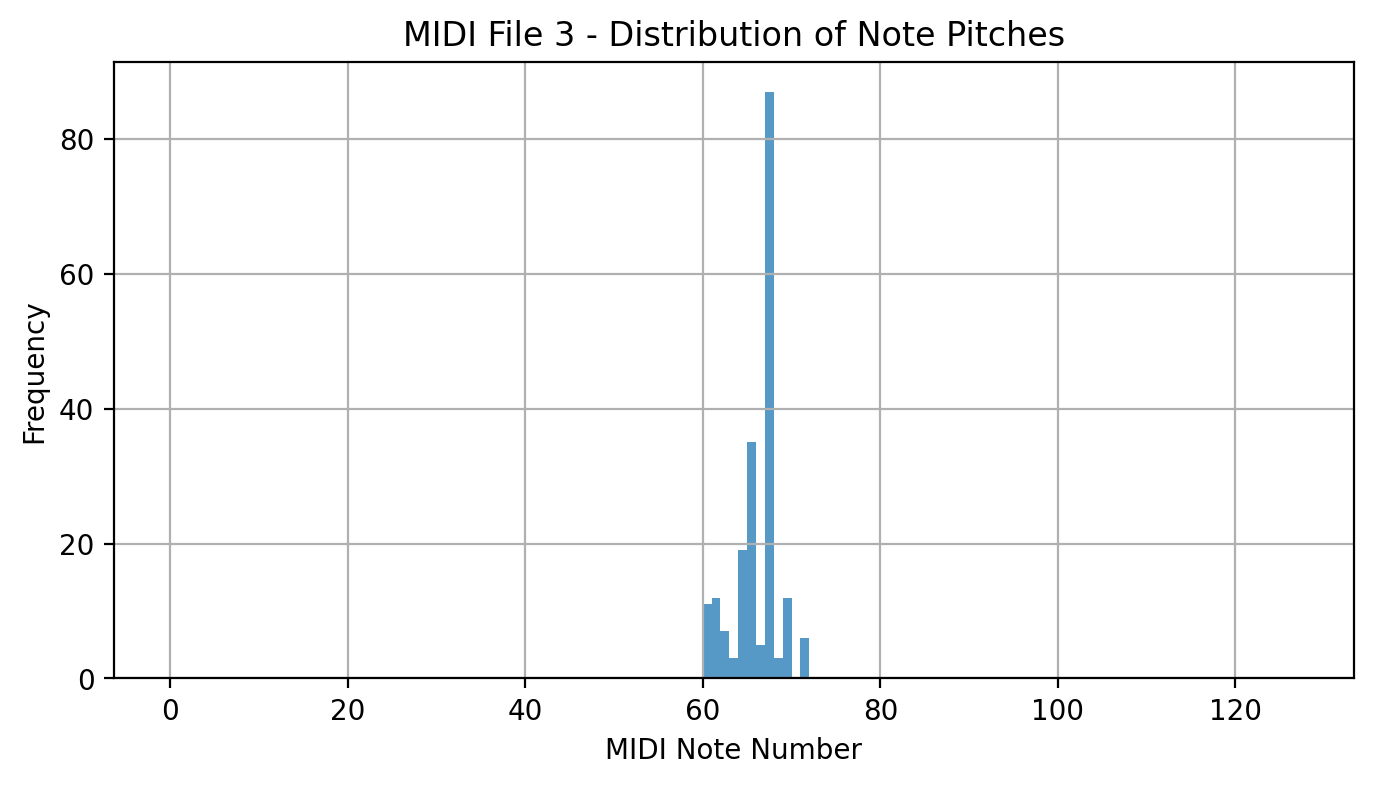

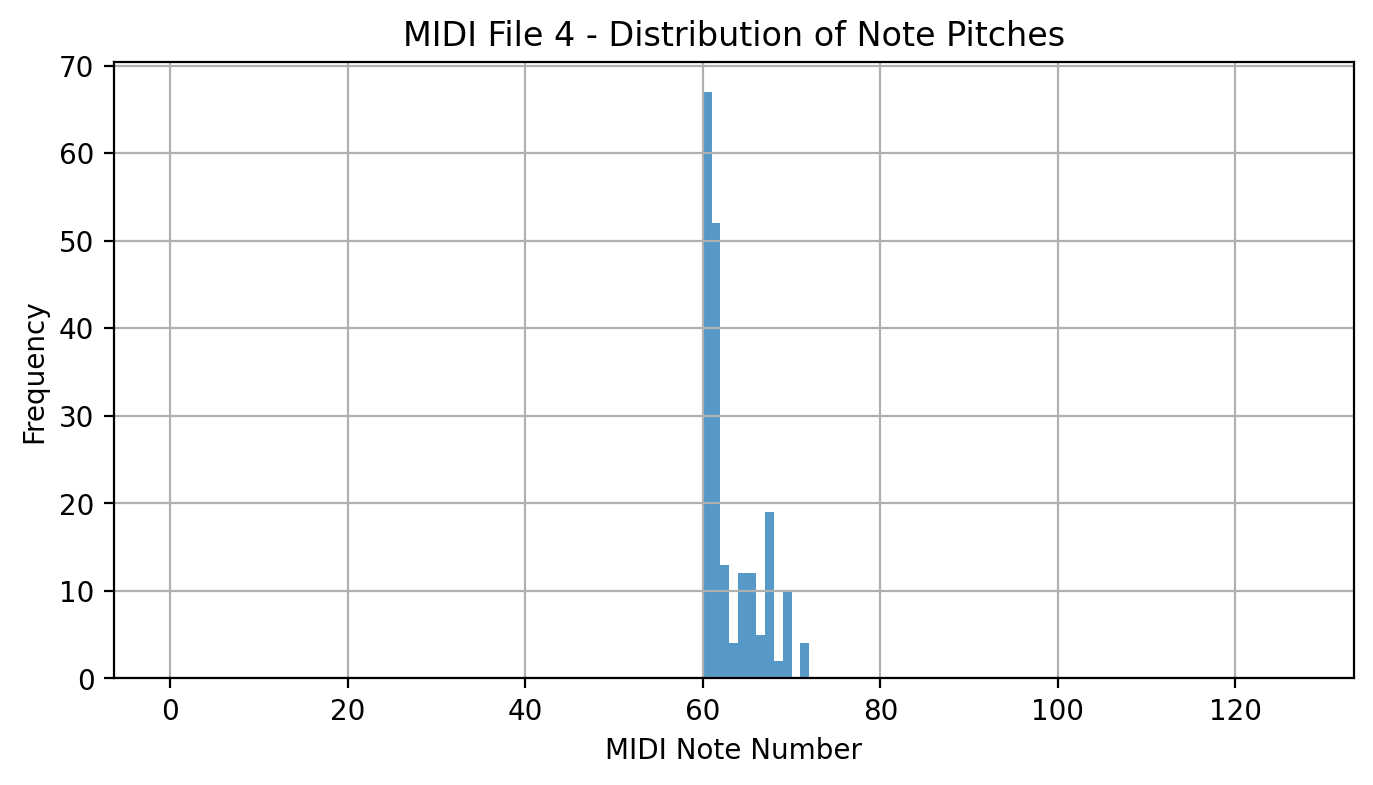

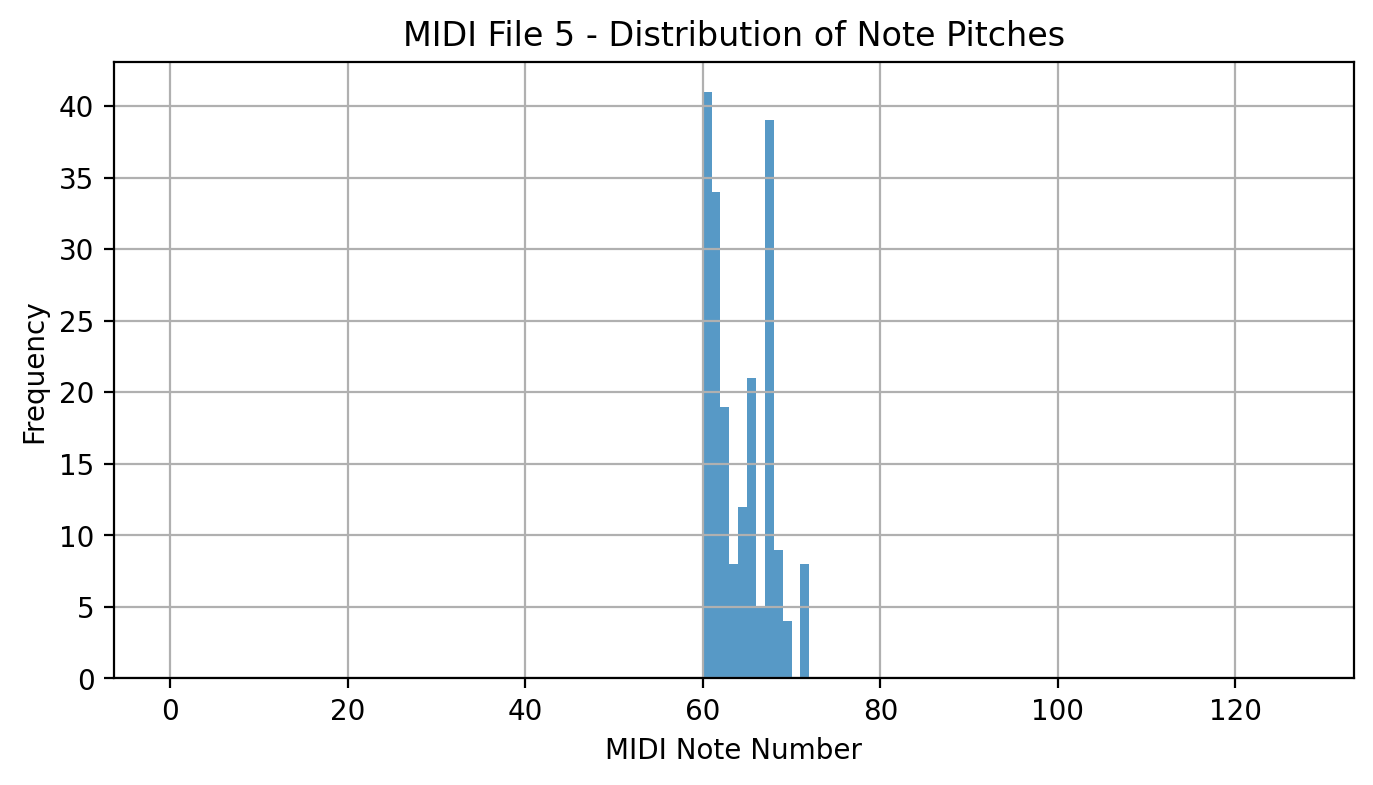

In [72]:
# Visualize the distribution of note pitches for each MIDI file
for i, midi_data in enumerate(loaded_midis):
    note_pitches = [note.pitch for note in midi_data.instruments[0].notes]
    plt.figure(figsize=(8, 4))
    plt.hist(note_pitches, bins=range(128), alpha=0.75)
    plt.title(f"MIDI File {i+1} - Distribution of Note Pitches")
    plt.xlabel("MIDI Note Number")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()